<img src="https://i.ytimg.com/vi/6k9gb2elXvo/maxresdefault.jpg" width="1200">

#  1. BUSINESS PROBLEM
## 1.1 Description
<p>An autonomous car is a vehicle that can guide itself without human conduction. It is also known as a driverless car, robot car, self-driving car or autonomous vehicle. ... Autonomous cars use various technologies- they may use GPS sensing knowledge for navigation, and various sensors to avoid collisions. There are many companies playing in this space- Google, Nvidia, Uber, Waymo are some of them.</p>
<p>
Deep Learning is one of ways to make autonomous driving possible. This case study will use Nvidia's “End to End Learning for Self-Driving Cars” network.
</p>

## 1.2 Problem Statement
- We are going to train a model that predict how the human was driving the car(steering angles)- essentially clones the driver’s behaviour to different road scenarios, given a series of front-dash images for 25 minutes.

# 2. DEEP LEARNING PROBLEM
## 2.1 Data
### 2.1.1 Data Overview
<b>Source :</b> https://github.com/SullyChen/driving-datasets/
<p> 
- Data will be in a file driving_dataset <br>
- It consits of approximately 45k images(25 minutes),2.2 GB. <br>
- Data format is as follows: filename.jpg angle<br>
</p>

###  2.1.2 Example Data point

<img src="https://cdn-images-1.medium.com/max/400/1*K23ZsauMM3TGyawi-Vc5PA.jpeg"  width="500">
<br>

16466.jpg -1.610000   
16467.jpg -1.710000  
16468.jpg -1.710000  
16469.jpg -1.920000  
16470.jpg -2.120000  
16471.jpg  0.000000  

## 2.2 Mapping the real world problem to an DL problem  
### 2.2.1 Type of Problem
<p> It is a <b>regression</b> problem, for a given front-dash images of road we need to predict the steering angle of car. </p>

### 2.2.2 Performance Metric
* MSE(Mean Squared Error)

# 3. EXPLORATORY DATA ANALYSIS

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import os
import random
from subprocess import call
import math
from datetime import datetime as dt

import cv2
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM,TimeDistributed,Reshape
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling1D,Flatten

import warnings
#import joblib

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 3.1 Loading the Data

In [2]:
DATA_FOLDER = "driving_dataset/"
TRAINFILE = os.path.join(DATA_FOLDER,"data.txt")

In [3]:
X_images = []
Y_strangles = []

start = dt.now()
with open(TRAINFILE) as f:
    for line in f:
        X_images.append(DATA_FOLDER+line.split()[0])
        Y_strangles.append(float(line.split()[1]) * sc.pi/180)
    print("Time taken to run this cell :",dt.now() - start)

Time taken to run this cell : 0:00:00.318442


In [4]:
print("Number of front-camera images in dataset :",len(X_images))

Number of front-camera images in dataset : 45406


## 3.2 Train and Test Split Ratio(70:30)

In [5]:
split_index = int(len(Y_strangles) * 0.7)

X_train = X_images[:split_index]
y_train = Y_strangles[:split_index]

X_test = X_images[split_index:]
y_test = Y_strangles[split_index:]

print("Number of Images in Training set :",len(X_train))
print("Number of Images in Test set :",len(X_test))

Number of Images in Training set : 31784
Number of Images in Test set : 13622


## 3.3 Distribution of Steering Angles in Train and Test

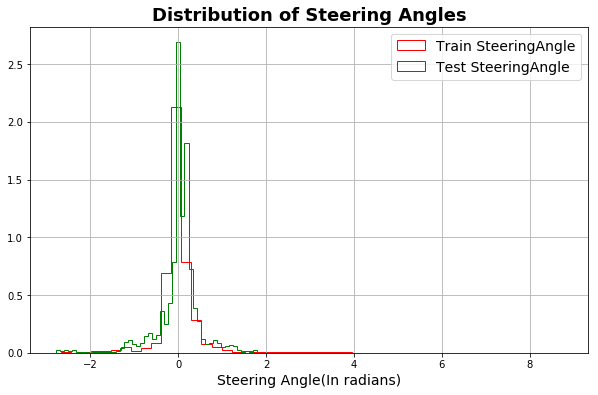

In [6]:
plt.figure(figsize = (10,6))
plt.hist(y_train, bins = 50, density = 1, color ='red', histtype = "step", label = "Train SteeringAngle")
plt.hist(y_test, bins = 50, density = 1, color ='green', histtype = "step", label = "Test SteeringAngle")
plt.title("Distribution of Steering Angles", fontsize = 18 ,fontweight = "bold")
plt.xlabel("Steering Angle(In radians)", fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

<b>Observations</b>
-  The training and test data is dominated by 0-steering angle most of the times(may be due to straight roads).
-  There are some left and right steering angles as well which could be due to turnings in roads.
-  Distribution of both and test data are almost similar.

# 4. BATCH LOAD OF DATASET

In [7]:
train_batch_pointer = 0
test_batch_pointer = 0

#Batch Load for training data
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    
    for i in range(0, batch_size):
        x_out.append(sc.misc.imresize(sc.misc.imread(X_train[(train_batch_pointer + i) % len(X_train)])[-150:], [66, 200]) / 255.0)
        y_out.append([y_train[(train_batch_pointer + i) % len(y_train)]])
    train_batch_pointer += batch_size
    
    return x_out, y_out

#Batch Load for test data
def LoadTestBatch(batch_size):
    global test_batch_pointer
    x_out = []
    y_out = []
    
    for i in range(0, batch_size):
        x_out.append(sc.misc.imresize(sc.misc.imread(X_test[(test_batch_pointer + i) % len(X_test)])[-150:], [66, 200]) / 255.0)
        y_out.append([y_test[(test_batch_pointer + i) % len(y_test)]])
    test_batch_pointer += batch_size
    
    return x_out, y_out

# 5. BUILDING THE MODEL

<img src="https://cdn-images-1.medium.com/max/1600/1*DvkLcBclo6D7q_vF94OEag.png" width="500">

We will use Nvidia’s Convolutional Neural Network(Pilot-Net Architecture).  
The network consists of 9 layers- 
-  a normalization layer
-  5 convolutional layers and 
-  3 fully connected layers. 

# 6. TRAINING THE MODEL

## 6.1 Training Model 1
-  Train-Test Split = 70:30
-  L2_NormConst = 0.001
-  Optimizer = ADAM
-  learning_rate = 1e-3
-  batch_size = 100
-  Dropout Rate = 0.5
-  Activation Unit in output layer = Linear

<b>Model 1 Architecture:</b>

In [8]:
def weight_variable(shape):
    w_initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(w_initial)

def bias_variable(shape):
    b_initial = tf.constant(0.1, shape = shape)
    return tf.Variable(b_initial)

def Conv2D(x, W, stride):
    conv_layer = tf.nn.conv2d(x, W, strides = [1,stride,stride,1], padding = 'VALID')
    return conv_layer

X = tf.placeholder(tf.float32, shape = [None, 66, 200, 3])
y = tf.placeholder(tf.float32, shape = [None, 1])

#First Convolutional Layer
W_conv1 = weight_variable([5, 5 ,3 ,24])
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(Conv2D(X, W_conv1, 2) + b_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5 ,24 ,36])
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(Conv2D(h_conv1, W_conv2, 2) + b_conv2)

#Third Convolutional Layer
W_conv3 = weight_variable([5, 5 ,36 ,48])
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(Conv2D(h_conv2, W_conv3, 2) + b_conv3)

#Fourth Convolutional Layer
W_conv4 = weight_variable([3, 3 ,48 ,64])
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(Conv2D(h_conv3, W_conv4, 1) + b_conv4)

#Fifth Convolutional Layer
W_conv5 = weight_variable([3, 3 ,64 ,64])
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(Conv2D(h_conv4, W_conv5, 1) + b_conv5)

#Flattening Layer
W_flat = weight_variable([1152,1164])
b_flat = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1,1152])
h_flat = tf.nn.relu(tf.matmul(h_conv5_flat, W_flat) + b_flat)

keep_prob = tf.placeholder(tf.float32)
h_flat_drop = tf.nn.dropout(h_flat, keep_prob)

#First Fully Connected Layer
W_fc1 = weight_variable([1164,100])
b_fc1 = bias_variable([100])

h_fc1 = tf.nn.relu(tf.matmul(h_flat_drop, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Second Fully Connected Layer
W_fc2 = weight_variable([100,50])
b_fc2 = bias_variable([50])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#Third Fully Connected Layer
W_fc3 = weight_variable([50,10])
b_fc3 = bias_variable([10])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#Output Layer(Linear Activation)
W_out = weight_variable([10,1])
b_out = bias_variable([1])
y_pred = tf.multiply(tf.identity(tf.matmul(h_fc3_drop, W_out) + b_out),2)

<b>Training of Model 1:</b>

In [11]:
warnings.filterwarnings("ignore")

LOGDIR = 'model'

sess = tf.InteractiveSession()

#constant for L2 Regularization
L2_NormConst = 0.001

train_vars = tf.trainable_variables()

# total-loss = mse + l2-reg
loss = tf.reduce_mean(tf.square(tf.subtract(y,y_pred))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2_NormConst

#Learning-rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)


epochs = 30
batch_size = 100
train_loss = []
test_loss = []

start = dt.now()
for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    
    for i in range(int(len(X_images)/batch_size)):
        
        X_train_batch, y_train_batch = LoadTrainBatch(batch_size)
        optimizer.run(feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob: 0.5})
        tr_loss = loss.eval(feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob: 1.0})
        train_avg_loss += (tr_loss/batch_size)
        
        X_test_batch, y_test_batch = LoadTestBatch(batch_size)
        val_loss = loss.eval(feed_dict = {X: X_test_batch, y: y_test_batch, keep_prob: 1.0})
        test_avg_loss += (val_loss/batch_size)
        
        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "final_model.ckpt")
            filename = saver.save(sess, checkpoint_path)
            
    print("Epoch: %d, Train-Loss: : %g, Test-Loss(MSE): %g" % (epoch, train_avg_loss, test_avg_loss))
    print("Model saved in file: %s" % filename)
    
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
print("Time taken to train the model :",dt.now() - start)

Epoch: 0, Train-Loss: : 15.4551, Test-Loss(MSE): 15.0137
Model saved in file: model/final_model.ckpt
Epoch: 1, Train-Loss: : 7.77524, Test-Loss(MSE): 7.63696
Model saved in file: model/final_model.ckpt
Epoch: 2, Train-Loss: : 5.52816, Test-Loss(MSE): 4.90996
Model saved in file: model/final_model.ckpt
Epoch: 3, Train-Loss: : 3.55445, Test-Loss(MSE): 3.5633
Model saved in file: model/final_model.ckpt
Epoch: 4, Train-Loss: : 3.36081, Test-Loss(MSE): 2.68381
Model saved in file: model/final_model.ckpt
Epoch: 5, Train-Loss: : 2.28151, Test-Loss(MSE): 2.14008
Model saved in file: model/final_model.ckpt
Epoch: 6, Train-Loss: : 2.03299, Test-Loss(MSE): 1.9023
Model saved in file: model/final_model.ckpt
Epoch: 7, Train-Loss: : 2.19711, Test-Loss(MSE): 1.63626
Model saved in file: model/final_model.ckpt
Epoch: 8, Train-Loss: : 1.6281, Test-Loss(MSE): 1.44813
Model saved in file: model/final_model.ckpt
Epoch: 9, Train-Loss: : 1.96447, Test-Loss(MSE): 1.42598
Model saved in file: model/final_mode

<b>Plot between Loss vs Epochs:</b>

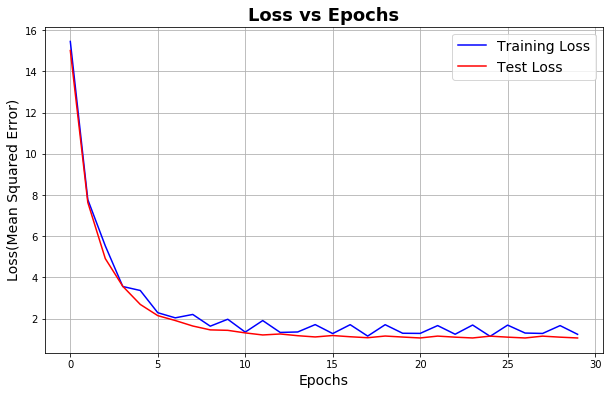

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, 'b', label = "Training Loss")
plt.plot(range(epochs), test_loss, 'r', label = "Test Loss")
plt.title("Loss vs Epochs",fontsize = 18, fontweight = "bold")
plt.xlabel("Epochs",fontsize = 14)
plt.ylabel("Loss(Mean Squared Error)",fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

## 6.2 Training Model 2 with slightly different parameters
-  Train-Test Split = 70:30
-  L2_NormConst = 0.0001
-  Optimizer = RMSProp
-  learning_rate = 1e-4
-  batch_size = 128
-  Dropout Rate = 0.7
-  Activation Unit in output layer = Arctan(tanh)

<b>Model 2 Architecture:</b>

In [10]:
def weight_variable(shape):
    w_initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(w_initial)

def bias_variable(shape):
    b_initial = tf.constant(0.1, shape = shape)
    return tf.Variable(b_initial)

def Conv2D(x, W, stride):
    conv_layer = tf.nn.conv2d(x, W, strides = [1,stride,stride,1], padding = 'VALID')
    return conv_layer

X = tf.placeholder(tf.float32, shape = [None, 66, 200, 3])
y = tf.placeholder(tf.float32, shape = [None, 1])

#First Convolutional Layer
W_conv1 = weight_variable([5, 5 ,3 ,24])
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(Conv2D(X, W_conv1, 2) + b_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5 ,24 ,36])
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(Conv2D(h_conv1, W_conv2, 2) + b_conv2)

#Third Convolutional Layer
W_conv3 = weight_variable([5, 5 ,36 ,48])
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(Conv2D(h_conv2, W_conv3, 2) + b_conv3)

#Fourth Convolutional Layer
W_conv4 = weight_variable([3, 3 ,48 ,64])
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(Conv2D(h_conv3, W_conv4, 1) + b_conv4)

#Fifth Convolutional Layer
W_conv5 = weight_variable([3, 3 ,64 ,64])
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(Conv2D(h_conv4, W_conv5, 1) + b_conv5)

#Flattening Layer
W_flat = weight_variable([1152,1164])
b_flat = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1,1152])
h_flat = tf.nn.relu(tf.matmul(h_conv5_flat, W_flat) + b_flat)

keep_prob = tf.placeholder(tf.float32)
h_flat_drop = tf.nn.dropout(h_flat, keep_prob)

#First Fully Connected Layer
W_fc1 = weight_variable([1164,100])
b_fc1 = bias_variable([100])

h_fc1 = tf.nn.relu(tf.matmul(h_flat_drop, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Second Fully Connected Layer
W_fc2 = weight_variable([100,50])
b_fc2 = bias_variable([50])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#Third Fully Connected Layer
W_fc3 = weight_variable([50,10])
b_fc3 = bias_variable([10])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#Output Layer
W_out = weight_variable([10,1])
b_out = bias_variable([1])
y_pred = tf.multiply(tf.atan(tf.matmul(h_fc3_drop, W_out) + b_out),2)

<b>Training of Model 2:</b>

In [11]:
warnings.filterwarnings("ignore")

LOGDIR = 'D:\\Soyam\Applied AI\\SelfDriving Car\\model2'

sess = tf.InteractiveSession()

#constant for L2 Regularization
L2_NormConst = 0.0001

train_vars = tf.trainable_variables()

# total-loss = mse + l2-reg
loss = tf.reduce_mean(tf.square(tf.subtract(y,y_pred))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2_NormConst

#Learning-rate = 0.0001
optimizer = tf.train.RMSPropOptimizer(learning_rate = 1e-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)


epochs = 30
batch_size = 128
train_loss = []
test_loss = []

start = dt.now()
for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    
    for i in range(int(len(X_images)/batch_size)):
        
        X_train_batch, y_train_batch = LoadTrainBatch(batch_size)
        optimizer.run(feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob: 0.7})
        tr_loss = loss.eval(feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob: 1.0})
        train_avg_loss += (tr_loss/batch_size)
        
        X_test_batch, y_test_batch = LoadTestBatch(batch_size)
        val_loss = loss.eval(feed_dict = {X: X_test_batch, y: y_test_batch, keep_prob: 1.0})
        test_avg_loss += (val_loss/batch_size)
        
        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "final_model2.ckpt")
            filename = saver.save(sess, checkpoint_path)
            
    print("Epoch: %d, Train-Loss: : %g, Test-Loss(MSE): %g" % (epoch, train_avg_loss, test_avg_loss))
    print("Model saved in file: %s" % filename)
    
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
print("Time taken to train the model :",dt.now() - start)

Epoch: 0, Train-Loss: : 6.06572, Test-Loss(MSE): 5.94425
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 1, Train-Loss: : 4.26511, Test-Loss(MSE): 4.22072
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 2, Train-Loss: : 3.31218, Test-Loss(MSE): 2.98863
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 3, Train-Loss: : 2.18373, Test-Loss(MSE): 2.24643
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 4, Train-Loss: : 1.91398, Test-Loss(MSE): 1.72063
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 5, Train-Loss: : 1.39703, Test-Loss(MSE): 1.43664
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 6, Train-Loss: : 1.14921, Test-Loss(MSE): 1.25339
Model saved in file: D:\Soyam\Applied AI\SelfDriving Car\model2\final_model2.ckpt
Epoch: 7, Train-Loss: : 1.2

<b>Plot between Loss vs Epochs:</b>

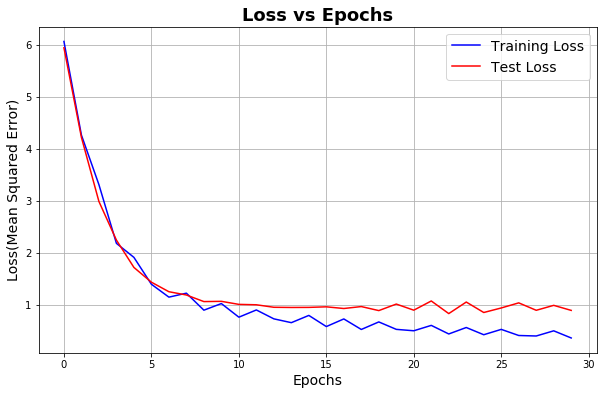

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, 'b', label = "Training Loss")
plt.plot(range(epochs), test_loss, 'r', label = "Test Loss")
plt.title("Loss vs Epochs",fontsize = 18, fontweight = "bold")
plt.xlabel("Epochs",fontsize = 14)
plt.ylabel("Loss(Mean Squared Error)",fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

# 7. TEST AND VISUALISE THE OUTPUT

In [ ]:
# warnings.filterwarnings("ignore")

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "D:\\Soyam\Applied AI\\SelfDriving Car\\model2\\final_model2.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape
smoothed_angle = 0

i = math.ceil(len(X_images)*0.2)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = sc.misc.imread(DATA_FOLDER + str(i) + ".jpg", mode="RGB")
    image = sc.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = y_pred.eval(feed_dict={X: [image], keep_prob: 1.0})[0][0] * 180.0 / sc.pi

    
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(Y_strangles[i]*180/sc.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()

<b>NOTE :</b> The above code is run to visualize the rotation of steering angles and the recoding is shared.

# 8. CONCLUSION

## 8.1 Steps Followed
-  Data Images are loaded and some basis statistics about the data is observed.
-  Data is divided to train and test in 70-30 ratio.
-  Exploaratory data analysis on Distribution of Steering angles is observed for both train and test.
-  Batch Loading of dataset is done to train the model in batches.
-  Our model is build following the same architecture of <b>NVIDEA's End-End CNN Deep Learning Model</b> with some tweaks in parameters.
-  Model is trained and test loss is plotted wrt epochs.
-  Test outputs is visualised by seeing how much the steering angle moves with the images of roads.

## 8.2 Model Performance

| DL Model |  <b>BatchSize</b> | <b>Train-Test Split</b> | <b>Output Layer Activation Unit</b> | <b>Droput rate</b> | <b>Learning Rate</b> | <b>Test MSE</b> |
| --- | --- | --- | --- | --- | --- |  --- |
| <b>NVIDEA End-End CNN Model</b> | 100 | 70:30 | Linear(Identity) | 0.5  | (ADAM)0.001  | 1.055 |
| <b>NVIDEA End-End CNN Model</b> | 128 | 70:30 | Arctan | 0.7  | (RMSprop)0.0001  | 0.88 |

-  Steering angle doesnot move at all with linear activation unit while visualising the outputs ie for every images it gives a constant steering angle of 1.759 degrees.(can be said as a dumb car as it goes only with one steering angle throughout).
-  <b>Model performs well when we take 'arctan' instead of 'linear' as activation unit in output Layer.We could observe steering angle being rotated where there is sharp turns in road.</b>